https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/mnist_with_summaries.py

In [1]:
%matplotlib inline
import tensorflow as tf
from utils.load_data import *
from utils.load_preprocessed import *
from utils.dataset import *
from utils.reporting import *
from utils.visualization import *

from IPython.display import display
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import IPython.display as ipyd
plt.style.use('ggplot')

# Configuration

In [2]:
data_base_dir = "../data/crop_4_20"
corpus_dir = "{}/corpus".format(data_base_dir)
bottleneck_dir = "{}/bottleneck".format(data_base_dir)

log_dir = "./test/logs"

In [3]:
face_cascade_dir = './utils/haarcascade_frontalface_default.xml'
eye_cascade_dir = './utils/haarcascade_eye.xml'

In [4]:
seed = 42

learning_rate_bottleneck = 0.00003
# learning_rate = 0.003
# learning_rate = 0.01
learning_rate = 0.001
epochs = 200
dropout_train = 0.75
dropout_test = 1.0

bottleneck_train = False
beta = 0.1

#Conv parameters
n_filters = [32, 32, 8]  #filter output sizes
filter_sizes = [4, 4, 2]  #
filter_strides = [1, 2, 2, 1]
#maxpool parameters
ksize = [1,2,2,1]
k_strides = [1,2,2,1]
#FC parameter
n_nodes = 100

#bottleneck layer
n_bottles = 2048


In [5]:
all_images, all_labels, all_bottles = load_preprocessed_data(corpus_dir, 
                                            bottleneck_dir)
x_4d_shape = all_images.shape
all_images = np.ravel(all_images).reshape(all_images.shape[0], 
        all_images.shape[1] * all_images.shape[2] * all_images.shape[3])

In [6]:
split = [0.8, 0.0, 0.2]
ds = Dataset(all_images, all_labels, all_bottles, split=split, one_hot=True, rnd_seed=seed)

n_samples = ds.X.shape[0]
n_features = ds.X.shape[1]
n_classes = ds.Y.shape[1]
train_mean = np.mean(ds.train.images,0)

x_4d_shape

(80, 100, 100, 3)

In [7]:
ds.train.labels[0:5]

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]], dtype=int32)

### Create placeholders

In [8]:
# Input placeholders
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, n_features], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, n_classes], name='y-input')
    z = tf.placeholder(tf.float32, [None, 2048], name='z-input')
    keep_prob = tf.placeholder(tf.float32)

with tf.name_scope('input_reshape'):
    x_4d = tf.reshape(x, [-1, x_4d_shape[1], x_4d_shape[2], x_4d_shape[3]])
    tf.summary.image('input', x_4d, 10)

### Create Variables for Weights and Variables

In [9]:
# We can't initialize these variables to 0 - the network will get stuck.

def weight_variable_xavier(name, shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.get_variable(
                            name=name,
                            shape=shape,
                            initializer=tf.contrib.layers.xavier_initializer_conv2d())
    return initial

def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, strides=[1,1,1,1]):
    return tf.nn.conv2d(x, W, strides=strides, padding='SAME')

def max_pool_2x2(x, ksize, strides):
    return tf.nn.max_pool(x, ksize=ksize,
                        strides=strides, padding='SAME')

### Create Summaries for all var to include min/max/mean/std_dev

In [10]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### Convolution function

In [11]:
#X must be 4D
def convolutions(X, n_filters, filter_sizes, filter_strides, activation=tf.nn.relu):
    current_in = X
    n_input_chs = X.get_shape().as_list()[3]
    Ws = []
    shapes = []

    # Build the encoder
    for layer_i, n_output_chs in enumerate(n_filters):
        with tf.variable_scope('convolution/{}'.format(layer_i)):
            shapes.append(current_in.get_shape().as_list())
            W = weight_variable_xavier(
                                name = "W{}".format(layer_i),
                                shape = [filter_sizes[layer_i], 
                                 filter_sizes[layer_i], 
                                 n_input_chs, n_output_chs])
            
            pre_activation = conv2d(current_in, W, filter_strides)
            h = activation(pre_activation)
            Ws.append(W)
            current_in = h
            n_input_chs = n_output_chs
            print("h.shape:", h.get_shape().as_list())
    shapes.append(current_in.get_shape().as_list())
    print("shapes:",shapes)
    return h, Ws

### Fully connected function

In [12]:
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.
    It does a matrix multiply, bias add, and then uses relu to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    if (len(input_tensor.get_shape().as_list())==4):
        input_shape = input_tensor.get_shape().as_list()
        input_tensor = tf.reshape(input_tensor, [-1, input_shape[1]*input_shape[2]*input_shape[3]])
    
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
      # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations, preactivate

In [13]:
def drop_layer(h, keep_prob):
    with tf.name_scope('dropout'):
        tf.summary.scalar('dropout_keep_probability', keep_prob)
        dropped = tf.nn.dropout(h, keep_prob)
    return dropped

### Create convolution layers

In [14]:
h, Ws = convolutions(x_4d, n_filters, filter_sizes, filter_strides)
h_shape = h.get_shape().as_list()
print("h.shape:", h.get_shape().as_list())
print("h[3]:", h.get_shape().as_list()[3])
print("Ws:", Ws)

h.shape: [None, 50, 50, 32]
h.shape: [None, 25, 25, 32]
h.shape: [None, 13, 13, 8]
shapes: [[None, 100, 100, 3], [None, 50, 50, 32], [None, 25, 25, 32], [None, 13, 13, 8]]
h.shape: [None, 13, 13, 8]
h[3]: 8
Ws: [<tensorflow.python.ops.variables.Variable object at 0x11a6e4be0>, <tensorflow.python.ops.variables.Variable object at 0x11e34d4a8>, <tensorflow.python.ops.variables.Variable object at 0x11e34db00>]


### Fully connected layer 1

In [15]:
hidden1, pre_act_1 = nn_layer(h, h_shape[1]*h_shape[2]*h_shape[3], n_nodes, 'layer1')
print(hidden1)

Tensor("layer1/activation:0", shape=(?, 100), dtype=float32)


### Drop layer

In [16]:
dropped = drop_layer(hidden1, keep_prob)
hidden2, pre_act_2 = nn_layer(dropped, n_nodes, n_nodes, 'layer2')

### Bottleneck layer

In [17]:
bottleneck, bottleneck_pre_act = nn_layer(hidden2, n_nodes, n_bottles, 'bottleneck')

### Output layer

In [18]:
y, pre_act_3 = nn_layer(bottleneck, n_bottles, n_classes, 'layer3', act=tf.identity)

### Cosine Distance

In [19]:
with tf.name_scope('cosine_distance'):
    sum = tf.reduce_sum(tf.multiply(bottleneck_pre_act, z), 1)
    a = tf.sqrt(tf.reduce_sum(tf.square(bottleneck_pre_act), 1))
    b = tf.sqrt(tf.reduce_sum(tf.square(z), 1))
    ab = tf.multiply(a,b)
    cosine_distance = tf.reduce_mean(1 - (tf.div(sum, ab)))
    cosine_distance_scaled = cosine_distance * beta

### Bottleneck cost function

In [20]:
loss_bottleneck = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(bottleneck, z)))
optimizer_bottleneck = tf.train.AdamOptimizer(learning_rate_bottleneck).minimize(loss_bottleneck)

### Cross entropy cost function

In [21]:
with tf.name_scope('cross_entropy'):
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    with tf.name_scope('total'):
        cross_entropy = tf.reduce_mean(diff)
tf.summary.scalar('cross_entropy', cross_entropy)

<tf.Tensor 'cross_entropy_1:0' shape=() dtype=string>

In [22]:
with tf.name_scope('train'):
#     train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy + cosine_distance_scaled) 
    

### Accuracy

In [23]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

### Summary writer and Create session

In [24]:
# Merge all the summaries and write them out to /tmp/tensorflow/mnist/logs/mnist_with_summaries (by default)
merged = tf.summary.merge_all()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options,
        allow_soft_placement=True, log_device_placement=True))  
sess.run(tf.global_variables_initializer())

train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
test_writer = tf.summary.FileWriter(log_dir + '/test')

### Step1: Train on Bottlenecks

In [25]:
if bottleneck_train:
    batch_size = 20

    for epoch_i in range(epochs):

        total_cost = []

        for batch_X, _, batch_Z in ds.train.next_batch(batch_size=batch_size):
            this_cost, _ = sess.run([loss_bottleneck, optimizer_bottleneck], feed_dict={x: batch_X - train_mean, z: batch_Z, keep_prob: dropout_train})
            total_cost = total_cost + this_cost

        if epoch_i%10 == 0:
            avg_cost = this_cost / (ds.X.shape[0] / batch_size)
            print(epoch_i, avg_cost)

### Step 2: Train on Image Class

In [26]:
batch_size = 20

finalRepresentations = []
for i in range(epochs):
    
    if i%10 == 0:
        # Train accuracy report
        summary, acc, zbottleneck_pre_act = sess.run([merged, accuracy, bottleneck_pre_act], feed_dict={x:ds.train.images - train_mean, 
                                                                                                       y_:ds.train.labels, 
                                                                                                       keep_prob: dropout_test})
        finalRepresentations.append(zbottleneck_pre_act)
        train_writer.add_summary(summary, i)
        print('Train accuracy at step %s: %s' % (i, acc))
    else:
        # Train network
        for batch_X, batch_Y, batch_Z in ds.train.next_batch(batch_size=batch_size):
            summary, _ = sess.run([merged, train_step], feed_dict={x: batch_X, 
                                                                   y_: batch_Y,
                                                                   z: batch_Z,
                                                                   keep_prob: dropout_train})
            train_writer.add_summary(summary, i)
            
# Test set accuracy
summary, acc, y = sess.run([merged, accuracy, y], feed_dict={x:ds.test.images - train_mean, 
                                                            y_:ds.test.labels, 
                                                            keep_prob: dropout_test})
test_writer.add_summary(summary, i)
print('Test Accuracy: %s' % (acc))

report(y, ds, n_classes)

train_writer.close()
test_writer.close()
#sess.close()

Train accuracy at step 0: 0.1875
Train accuracy at step 10: 0.328125
Train accuracy at step 20: 0.390625
Train accuracy at step 30: 0.390625
Train accuracy at step 40: 0.375
Train accuracy at step 50: 0.421875
Train accuracy at step 60: 0.375
Train accuracy at step 70: 0.40625
Train accuracy at step 80: 0.34375
Train accuracy at step 90: 0.34375
Train accuracy at step 100: 0.375
Train accuracy at step 110: 0.453125
Train accuracy at step 120: 0.46875
Train accuracy at step 130: 0.453125
Train accuracy at step 140: 0.390625
Train accuracy at step 150: 0.359375
Train accuracy at step 160: 0.515625
Train accuracy at step 170: 0.484375
Train accuracy at step 180: 0.375
Train accuracy at step 190: 0.484375
Test Accuracy: 0.4375

Train Class Distribution


,0,1,2,3
distribution,17,15,17,15



Test Class Distribution


,0,1,2,3
distribution,3,5,3,5



Train Results


,value
prec ovall,0.447
recall overall,0.383
f1 overall,0.323



Test Results by Class


,0,1,2,3
prec,0.333,0.455,0.0,1.000
recall,0.333,1.000,0.0,0.200
f1,0.333,0.625,0.0,0.333


## Other Results

### Activation

In [27]:
g = tf.get_default_graph()
# [op.name for op in g.get_operations()]

(1, 30000)


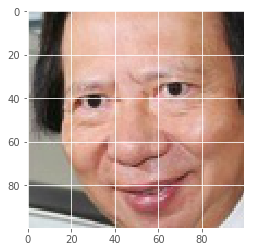

In [28]:
#pick an image from the test set
img_sel = ds.test.images[0]

img_conv = np.expand_dims(img_sel, axis=0).astype(np.uint8)
print(img_conv.shape)

plt.imshow(img_conv.reshape(x_4d_shape[1],x_4d_shape[2],x_4d_shape[3]))

In [29]:
conv_out= g.get_tensor_by_name('convolution/0/Relu:0')
img_conv = np.expand_dims(img_sel, axis=0)
conv_layer = conv_out.eval(session=sess, feed_dict={x:img_conv})
conv_layer.shape

(1, 50, 50, 32)

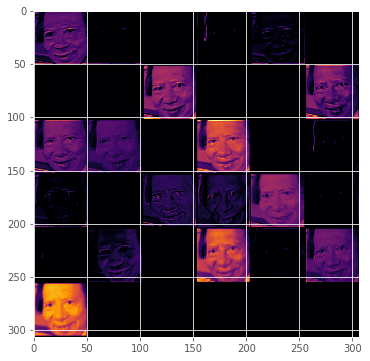

In [30]:
# Activations of the first convolution layer
mont_conv = montage_filters(np.rollaxis(np.expand_dims(conv_layer[0], 3), 3, 2))
plt.figure(figsize=(6,6))
plt.imshow(mont_conv, cmap='inferno')

## T-SNE

#### Reduce the dimensions to two to view how the celeberity images are clustering

In [31]:
finalRepresentations[-1].shape

(64, 2048)

In [32]:
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000)
lowDWeights = tsne.fit_transform(finalRepresentations[-1])

In [33]:
y_target_idx = np.argmax(ds.train.labels, 1)

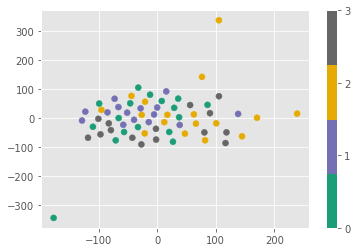

In [34]:
plt.scatter(lowDWeights[:,0], lowDWeights[:,1], c = y_target_idx, cmap=plt.cm.get_cmap('Dark2', n_classes))
plt.colorbar(ticks=range(n_classes))